In [82]:
import numpy as np
import cv2
from torch.fft import fft2, fftshift
import matplotlib.pyplot as plt
from PIL import Image
from torchmetrics.image import PeakSignalNoiseRatio
import torch
import torchvision.transforms as transforms

In [83]:
def compute_fourier_mag_spectrum(img):
    f = fft2(img)
    fshift = fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    return magnitude_spectrum

In [84]:
path = "/home/jakobtroidl/Desktop/neural-volumes/logs/hemibrain-volume-noisy-test-gradient-regularizer/results_iteration_86/15548_15559_15781/result/result_0_psnr_19,80945963369335.png"
image1 = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

path = "/home/jakobtroidl/Desktop/neural-volumes/logs/hemibrain-volume-noisy-test-gradient-regularizer/results_iteration_86/15548_15559_15781/gt/gt_0.png"
image2 = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

im1_spectrum = compute_fourier_mag_spectrum(image1)
im2_spectrum = compute_fourier_mag_spectrum(image2)


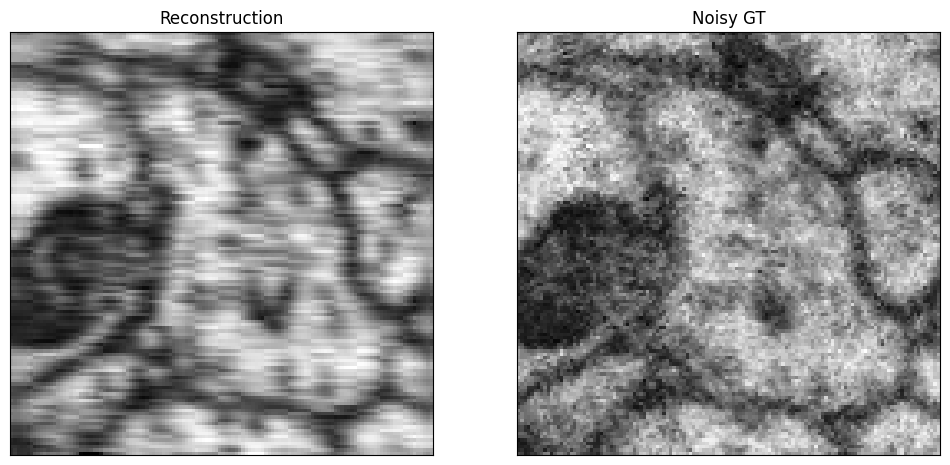

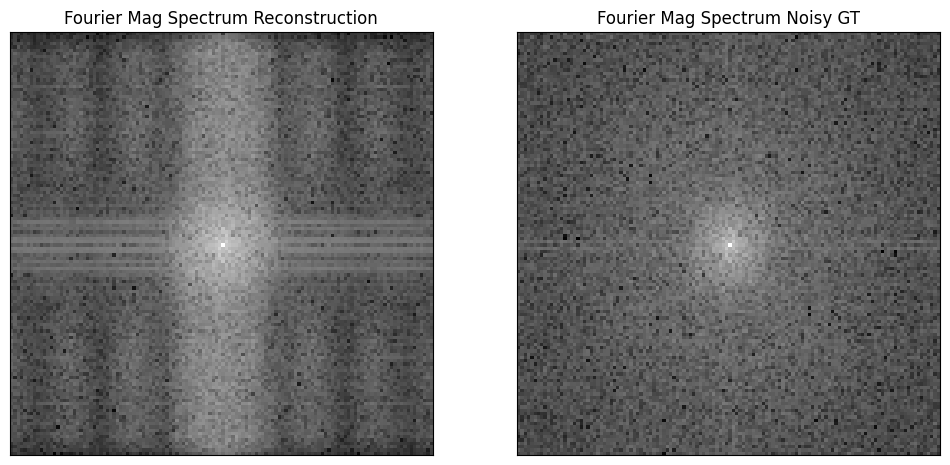

In [85]:
# Display the original, denoised images, and the difference
plt.figure(figsize=(12, 6))

plt.subplot(121), plt.imshow(image1.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Reconstruction'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(image2.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Noisy GT'), plt.xticks([]), plt.yticks([])

plt.show()


# Display the original, denoised images, and the difference
plt.figure(figsize=(12, 6))

plt.subplot(121), plt.imshow(im1_spectrum.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Fourier Mag Spectrum Reconstruction'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(im2_spectrum.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Fourier Mag Spectrum Noisy GT'), plt.xticks([]), plt.yticks([])

plt.show()



In [86]:
def fourier_denoiser(img, radius):
    # Compute the 2D Fourier Transform of the image
    f_transform = np.fft.fft2(img)
    f_shifted = np.fft.fftshift(f_transform)

    # Create a low-pass filter mask (circular mask)
    rows, cols = img.shape
    crow, ccol = rows // 2 , cols // 2
    radius = 20 # Radius of the low-pass filter, adjust as needed
    low_pass = np.zeros((rows, cols), dtype=np.uint8)
    y, x = np.ogrid[:rows, :cols]
    mask_area = (x - ccol) ** 2 + (y - crow) ** 2 <= radius**2
    low_pass[mask_area] = 1

    # Apply the mask/filter
    f_shifted_filtered = f_shifted * low_pass

    # Inverse Fourier Transform to get the denoised image back
    f_ishifted = np.fft.ifftshift(f_shifted_filtered)
    img_back = np.fft.ifft2(f_ishifted)
    return np.abs(img_back)


In [87]:
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

## Fourier-based denoising 

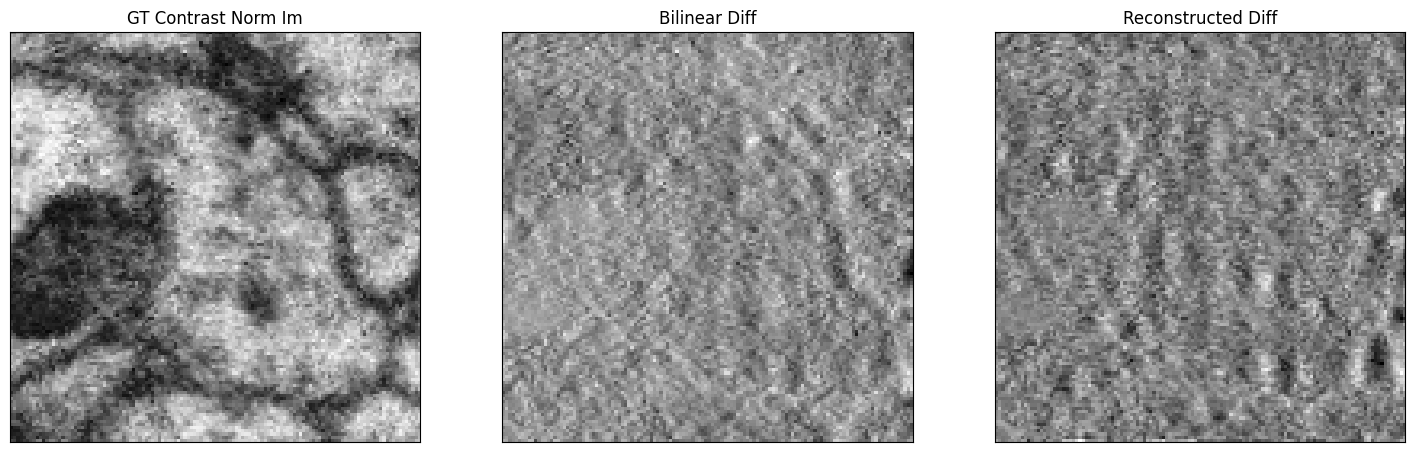

---------------------------------------
PSNR of Noisy Images: 
Bilinear interpolation:  tensor(20.3693)
Reconstructed interpolation:  tensor(19.6594)
---------------------------------------
PSNR of Denoised Images: 
Bilinear interpolation:  tensor(23.3081)
Reconstructed interpolation:  tensor(22.4670)


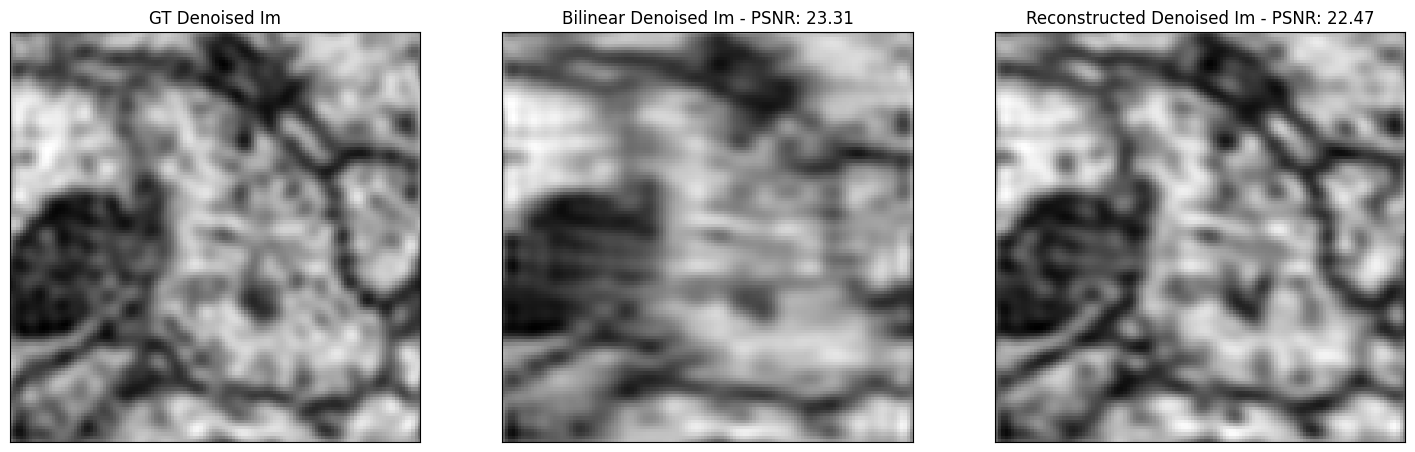

In [91]:
# Load the image (converting to grayscale)
rec_path = "/home/jakobtroidl/Desktop/neural-volumes/logs/hemibrain-volume-noisy-test-gradient-regularizer/results_iteration_86/15548_15559_15781/result/result_0_psnr_19,80945963369335.png"
rec_image = Image.open(rec_path).convert('L')

gt_path = "/home/jakobtroidl/Desktop/neural-volumes/logs/hemibrain-volume-noisy-test-gradient-regularizer/results_iteration_86/15548_15559_15781/gt/gt_0.png"
gt_image = Image.open(gt_path).convert('L')

bilinear_path = "/home/jakobtroidl/Desktop/neural-volumes/logs/hemibrain-volume-noisy-test-gradient-regularizer/results_iteration_86/15548_15559_15781/bilinear/bilinear_0_psnr_20,85474859157829.png"
bilinear_image = Image.open(bilinear_path).convert('L')

# Define a transform pipeline
transform = transforms.Compose([
    transforms.Grayscale(),         # Convert to grayscale
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5]), # Normalize pixel values
])

normalized_gt = transform(gt_image).squeeze().numpy()
normalized_bilinear = transform(bilinear_image).squeeze().numpy()
normalized_reconstructed = transform(rec_image).squeeze().numpy()

# normalize above images between 0 and 1
normalized_gt = normalize(normalized_gt)
normalized_bilinear = normalize(normalized_bilinear)
normalized_reconstructed = normalize(normalized_reconstructed)


bilinear_diff = normalize(normalized_gt - normalized_bilinear)
reconstructed_diff = normalize(normalized_gt - normalized_reconstructed)

# Display the original and denoised images
plt.figure(figsize=(18, 6))

plt.subplot(131), plt.imshow(normalized_gt, cmap='gray')
plt.title('GT Contrast Norm Im'), plt.xticks([]), plt.yticks([])

plt.subplot(132), plt.imshow(bilinear_diff, cmap='gray')
plt.title('Bilinear Diff'), plt.xticks([]), plt.yticks([])

plt.subplot(133), plt.imshow(reconstructed_diff, cmap='gray')
plt.title('Reconstructed Diff'), plt.xticks([]), plt.yticks([])

plt.show()

rec_denoised = fourier_denoiser(normalized_reconstructed, 20)
gt_denoised = fourier_denoiser(normalized_gt, 20)
bilinear_denoised = fourier_denoiser(normalized_bilinear, 20)
gt_denoised = normalize(gt_denoised)


psnr = PeakSignalNoiseRatio(data_range=(0, 1))

# Compute the PSNR of the original and denoised images
psnr_bilinear_noisy = psnr(torch.from_numpy(normalized_bilinear), torch.from_numpy(normalized_gt))
psnr_rec_nosiy = psnr(torch.from_numpy(normalized_reconstructed), torch.from_numpy(normalized_gt))

psnr_bilinear = psnr(torch.from_numpy(bilinear_denoised), torch.from_numpy(gt_denoised))
psnr_rec = psnr(torch.from_numpy(rec_denoised), torch.from_numpy(gt_denoised))

print("---------------------------------------")
print("PSNR of Noisy Images: ")
print("Bilinear interpolation: ", psnr_bilinear_noisy)
print("Reconstructed interpolation: ", psnr_rec_nosiy)

print("---------------------------------------")
print("PSNR of Denoised Images: ")
print("Bilinear interpolation: ", psnr_bilinear)
print("Reconstructed interpolation: ", psnr_rec)

# Display the original and denoised images
plt.figure(figsize=(18, 6))

plt.subplot(131), plt.imshow(gt_denoised, cmap='gray')
plt.title('GT Denoised Im'), plt.xticks([]), plt.yticks([])

plt.subplot(132), plt.imshow(bilinear_denoised, cmap='gray')
plt.title('Bilinear Denoised Im - PSNR: {}'.format(round(psnr_bilinear.item(), 2))), plt.xticks([]), plt.yticks([])

plt.subplot(133), plt.imshow(rec_denoised, cmap='gray')
plt.title('Reconstructed Denoised Im - PSNR: {}'.format(round(psnr_rec.item(), 2))), plt.xticks([]), plt.yticks([])

plt.show()

### Plot Difference Images

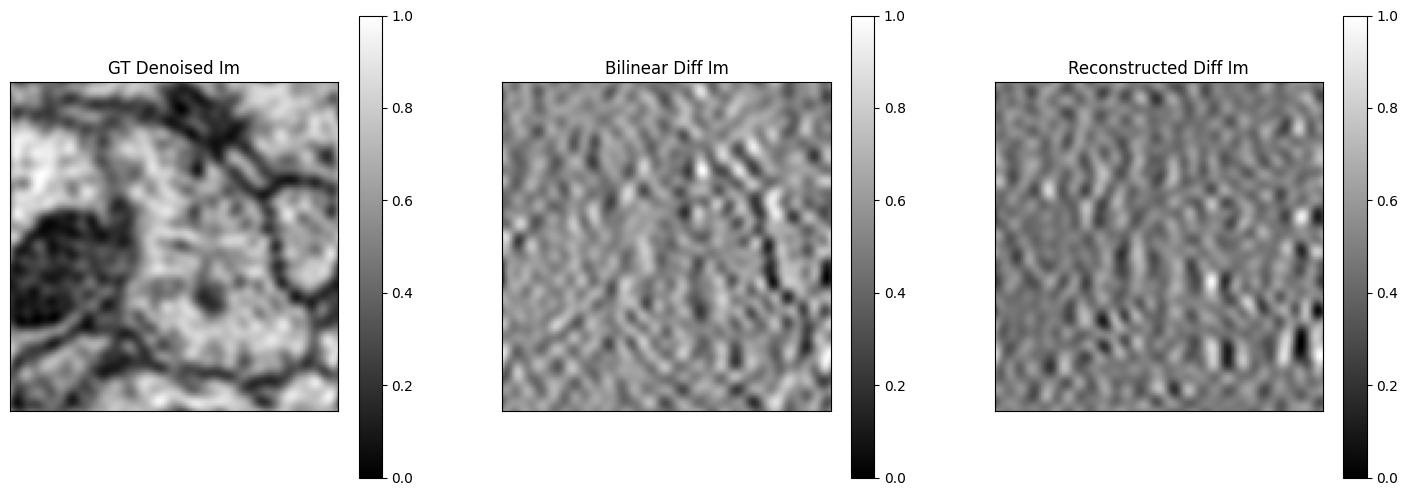

In [89]:
diff_rec = gt_denoised - rec_denoised
diff_bilinear = gt_denoised - bilinear_denoised


# normalize above images between 0 and 1
diff_rec = (diff_rec - np.min(diff_rec)) / (np.max(diff_rec) - np.min(diff_rec))
diff_bilinear = (diff_bilinear - np.min(diff_bilinear)) / (np.max(diff_bilinear) - np.min(diff_bilinear))

# Display the original and denoised images
plt.figure(figsize=(18, 6))

plt.subplot(131), plt.imshow(gt_denoised, cmap='gray')
plt.title('GT Denoised Im'), plt.xticks([]), plt.yticks([])
plt.colorbar()

plt.subplot(132), plt.imshow(diff_bilinear, cmap='gray')
plt.title('Bilinear Diff Im'), plt.xticks([]), plt.yticks([])
plt.colorbar()

plt.subplot(133), plt.imshow(diff_rec, cmap='gray')
plt.title('Reconstructed Diff Im'), plt.xticks([]), plt.yticks([])
plt.colorbar()

plt.show()

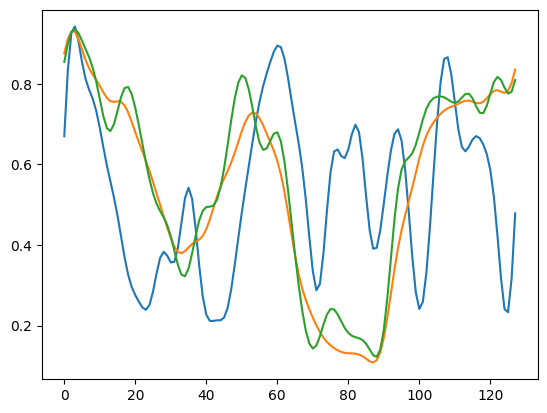

PSNR of the bilinear denoised row:  tensor(11.1355)
PSNR of the reconstructed denoised row:  tensor(11.1047)


In [90]:
gt_row = gt_denoised[50].squeeze()
plt.plot(gt_row)

bilinear_row = bilinear_denoised[20].squeeze()
plt.plot(bilinear_row)

rec_row = rec_denoised[20].squeeze()
plt.plot(rec_row)

plt.show()

# compute PSNR for rows
psnr_bilinear = psnr(torch.from_numpy(bilinear_row), torch.from_numpy(gt_row))
psnr_rec = psnr(torch.from_numpy(rec_row), torch.from_numpy(gt_row))

print("PSNR of the bilinear denoised row: ", psnr_bilinear)
print("PSNR of the reconstructed denoised row: ", psnr_rec)